In [ ]:
import pandas as pd
from ast import literal_eval
file_path: str = "data/prepared_sms_data.csv"
file_path_parquet: str = "data/prepared_sms_data.parquet"
text_column: str = "preprocessed_text"

# alternative: df = pd.read_csv(file_path, converters={"preprocessed_text": literal_eval})
df = pd.read_parquet(file_path_parquet)
df.head(5)

,label,text,preprocessed_text
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point,, crazy.., available, bugis..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar..., joking, wif, u, oni...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor..., u, c, already, sa..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, think, goes, usf,, lives, around, though]"


In [44]:
df[text_column] = df[text_column].apply(" ".join)

In [45]:
### Prepare splits
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, stratify=df['label'])

In [46]:
train['label'].value_counts()

label
ham     3613
spam     522
Name: count, dtype: int64

In [47]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train = le.fit_transform(train['label'])
Y_test = le.transform(test['label'])

In [48]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# TODO: add Tfidf vectorizer here, update the following code and compare results later
tfidf_vec = TfidfVectorizer()
X_train_tfidf = tfidf_vec.fit_transform(train[text_column])
X_test_tfidf = tfidf_vec.transform(test[text_column])

vec = CountVectorizer()
X_train = vec.fit_transform(train[text_column])
X_test = vec.transform(test[text_column])

In [49]:
# TODO we will take accuracy for the beginning. Which metric would be more suitable and why? Answer: F1-Score is more suitable for imbalanced datasets, as it considers both precision and recall. Accuracy can be misleading in such cases, as it may not reflect the true performance of the model on minority classes.

In [50]:
results = []

def get_name(classifier):
    return type(classifier).__name__

In [51]:
# TODO: What is the baseline for random classification and majority vote?
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, Y_train)
score = dummy.score(X_test, Y_test)

results.append([get_name(dummy)+"_most_frequent", score, "count_vec"])

dummy = DummyClassifier(strategy="uniform")
dummy.fit(X_train, Y_train)
score = dummy.score(X_test, Y_test)

results.append([get_name(dummy)+"_random_uniform", score, "count_vec"])

In [52]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB().fit(X_train, Y_train)
score = nb_model.score(X_test, Y_test)

results.append([get_name(nb_model), score, "count_vec"])

nb_model = MultinomialNB().fit(X_train_tfidf, Y_train)
score = nb_model.score(X_test_tfidf, Y_test)

results.append([get_name(nb_model), score, "tfidf_vec"])

In [53]:
from sklearn.tree import DecisionTreeClassifier

max_depth = 3
# TODO: configure the max depth of the decision tree
dt_model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train, Y_train)
score = dt_model.score(X_test, Y_test)

results.append([get_name(dt_model), score, "count_vec"])

dt_model = DecisionTreeClassifier(max_depth=max_depth).fit(X_train_tfidf, Y_train)
score = dt_model.score(X_test_tfidf, Y_test)

results.append([get_name(dt_model), score, "tfidf_vec"])

[Text(0.5, 0.875, 'call <= 0.088\ngini = 0.221\nsamples = 4135\nvalue = [3613, 522]\nclass = ham'),
 Text(0.25, 0.625, 'txt <= 0.057\ngini = 0.141\nsamples = 3762\nvalue = [3474, 288]\nclass = ham'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'www <= 0.066\ngini = 0.102\nsamples = 3660\nvalue = [3463, 197]\nclass = ham'),
 Text(0.0625, 0.125, 'gini = 0.084\nsamples = 3621\nvalue = [3462, 159]\nclass = ham'),
 Text(0.1875, 0.125, 'gini = 0.05\nsamples = 39\nvalue = [1, 38]\nclass = spam'),
 Text(0.375, 0.375, 'txt <= 0.19\ngini = 0.192\nsamples = 102\nvalue = [11, 91]\nclass = spam'),
 Text(0.3125, 0.125, 'gini = 0.046\nsamples = 85\nvalue = [2, 83]\nclass = spam'),
 Text(0.4375, 0.125, 'gini = 0.498\nsamples = 17\nvalue = [9, 8]\nclass = ham'),
 Text(0.75, 0.625, 'call <= 0.146\ngini = 0.468\nsamples = 373\nvalue = [139, 234]\nclass = spam'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'me <= 0.069\ngini = 0.202\nsamples = 210\nvalue = [24, 186]\nclass = spam'),
 Text(0.5

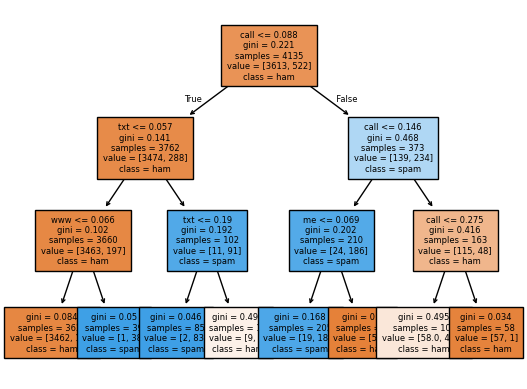

In [54]:
# TODO visualize the decision tree (https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html)
from sklearn.tree import plot_tree
plot_tree(dt_model, filled=True, feature_names=vec.get_feature_names_out(), class_names=le.classes_, fontsize=6)

In [55]:
# train also a random forest classifer and a linear svc
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier().fit(X_train, Y_train)
score = rf_model.score(X_test, Y_test)
results.append([get_name(rf_model), score, "count_vec"])

rf_model = RandomForestClassifier().fit(X_train_tfidf, Y_train)
score = rf_model.score(X_test_tfidf, Y_test)
results.append([get_name(rf_model), score, "tfidf_vec"])

from sklearn.svm import LinearSVC

svc_model = LinearSVC().fit(X_train, Y_train)
score = svc_model.score(X_test, Y_test)
results.append([get_name(svc_model), score, "count_vec"])

svc_model = LinearSVC().fit(X_train_tfidf, Y_train)
score = svc_model.score(X_test_tfidf, Y_test)
results.append([get_name(svc_model), score, "tfidf_vec"])

## All results

In [56]:
result_df = pd.DataFrame(results, columns=["classifer", "accuracy", "vectorizer"])
result_df.sort_values(by=["accuracy"])

,classifer,accuracy,vectorizer
1,DummyClassifier_random_uniform,0.494197,count_vec
0,DummyClassifier_most_frequent,0.873308,count_vec
4,DecisionTreeClassifier,0.918762,count_vec
5,DecisionTreeClassifier,0.930368,tfidf_vec
3,MultinomialNB,0.960348,tfidf_vec
7,RandomForestClassifier,0.968085,tfidf_vec
6,RandomForestClassifier,0.971954,count_vec
9,LinearSVC,0.977756,tfidf_vec
2,MultinomialNB,0.979691,count_vec
8,LinearSVC,0.982592,count_vec
